In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a descompose a covariance matrix with the spectral theorem and then we train a convolutional autoencoter to learn to generate fake covariance matrices. 

#### First, we need to read the data. In this case, we use the covariance matrix of systematic erros from Pantheon compilation of SN-1a 

In [2]:
syscov = np.loadtxt('https://raw.githubusercontent.com/ja-vazquez/SimpleMC/master/simplemc/data/pantheon_sys_full_long.txt',skiprows=1).reshape((1048,1048))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

3

### Visualization of the covariance matrix:

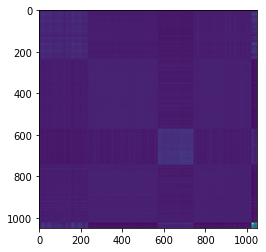

In [4]:
plt.imshow(syscov)

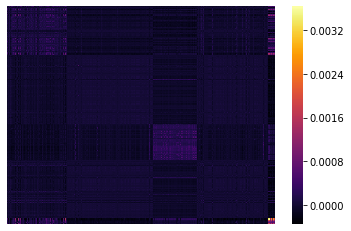

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')


In [6]:
np.min(syscov.diagonal()) #checking non-negatives in the diagonal

3.5145e-05

### Use matrix descomposition (spectral theorem)

### $\Sigma = P D P^T$

#### where P is an orthogonal matrix with the eigenvectors from $\Sigma$ and D a diagonal matrix with its eigenvalues.

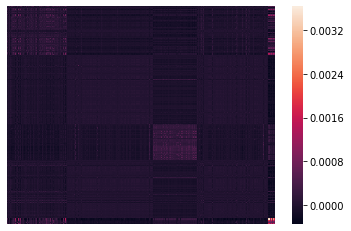

In [7]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
D, P = sp.linalg.eigh(syscov)
D = np.diag(D)
rec_cov = P @ D @ P.T
sns.heatmap(pd.DataFrame(rec_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, )

#### Checking that there are not complex values

In [8]:
count = 0

for i in range(len(P)):
    for j in range(len(P)):
        if np.iscomplex(P[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)

0


### Visualization of the eigenvector matrix $P$

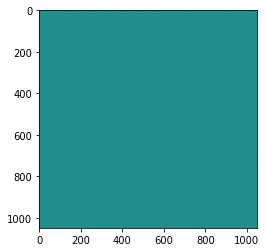

In [9]:
plt.imshow(P)

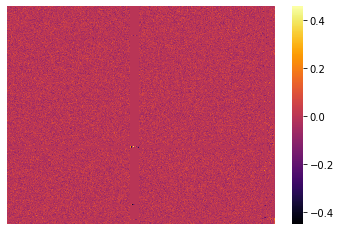

In [10]:
sns.heatmap(pd.DataFrame(P), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

### Generate a data set with matrices of eigenvectors from the original plus gaussian noise

In [11]:
numMatrix = 100
noise_factor = 1e-5
# scaler = StandardScaler()
# feature_range=(-1,1)
# scaler.fit(ortM)
pset = np.zeros((numMatrix, 1048, 1048))
for i in range(numMatrix): 
    pset[i] = P + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=P.shape) 
#     eigenvecdata[i] = scaler.transform(eigenvecdata[i])


In [12]:
print(np.shape(pset))

(100, 1048, 1048)


(100, 1048, 1048)
(20, 1048, 1048) (80, 1048, 1048)


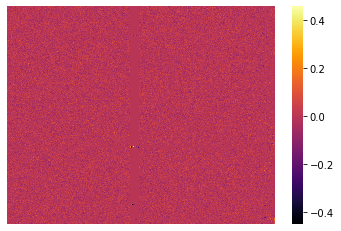

In [13]:
print(np.shape(pset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
pset_train, pset_test = np.split(pset, indx, axis=0)
print(np.shape(pset_test), np.shape(pset_train))
sns.heatmap(pd.DataFrame(pset_test[0, :, :]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [14]:

input_cov = Input(shape=(1048, 1048, 1))

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(input_cov)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)

x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoded = Dense(1048)(x)
x = Dense(131*131*2)(encoded)
x = layers.Reshape((131,131,2))(x)

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = tf.keras.Model(input_cov, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1048, 1048, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1048, 1048, 2)     20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 524, 524, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 524, 524, 4)       76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 262, 262, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 262, 262, 2)       74        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 131, 131, 2)      

In [15]:
autoencoder_train = autoencoder.fit(pset_train, pset_train,
                epochs=20,
                batch_size=16,
#                 shuffle=True,
                validation_data=(pset_test, pset_test))
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
5/5 [==============================] - 30s 6s/step - loss: 0.0023 - val_loss: 0.0049
Epoch 2/20
5/5 [==============================] - 33s 7s/step - loss: 0.0032 - val_loss: 1.2044e-04
Epoch 3/20
5/5 [==============================] - 33s 7s/step - loss: -1.8585e-04 - val_loss: -3.7330e-04
Epoch 4/20
5/5 [==============================] - 30s 6s/step - loss: -5.3795e-04 - val_loss: -7.5852e-04
Epoch 5/20
5/5 [==============================] - 32s 6s/step - loss: -8.4176e-04 - val_loss: -0.0011
Epoch 6/20
5/5 [==============================] - 35s 7s/step - loss: -0.0013 - val_loss: -0.0014
Epoch 7/20
5/5 [==============================] - 38s 8s/step - loss: -0.0015 - val_loss: -0.0017
Epoch 8/20
5/5 [==============================] - 34s 7s/step - loss: -0.0017 - val_loss: -0.0017
Epoch 9/20
5/5 [==============================] - 41s 8s/step - loss: -0.0018 - val_loss: -0.0019
Epoch 10/20
5/5 [==============================] - 43s 9s/step - loss: -0.0019 - val_loss: -0.0020

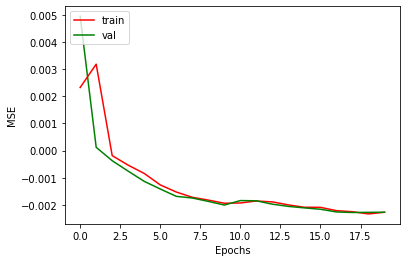

In [16]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [17]:
print(np.shape(pset_test))
decoded_imgs = autoencoder.predict(pset_test)
decoded_imgs[0, :, :, 0]

(20, 1048, 1048)


array([[ 4.9139792e-03,  1.0728208e-02,  8.0488361e-03, ...,
         3.0151124e-03,  3.2736470e-03,  1.9975847e-03],
       [-1.0039739e-02, -1.8746883e-02, -3.1362645e-02, ...,
        -2.8372672e-04,  1.7257059e-03, -1.6397301e-03],
       [-1.0466725e-02, -1.6756054e-02, -2.8952401e-02, ...,
        -4.9573006e-03, -1.9887572e-03, -2.0484703e-03],
       ...,
       [ 3.2159430e-03,  2.1856674e-04, -1.9721135e-03, ...,
        -2.0917436e-02, -2.0646604e-02, -1.8660942e-02],
       [ 2.2808509e-03, -1.0465917e-03, -2.0663461e-03, ...,
        -1.8242903e-02, -1.7718779e-02, -1.4834646e-02],
       [-5.3978292e-05,  1.4104139e-03,  2.8708288e-03, ...,
        -1.2684809e-02, -1.0647566e-02, -6.5434463e-03]], dtype=float32)

(20, 1048, 1048, 1)
(20, 1048, 1048, 1)


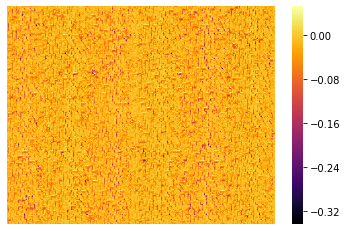

In [27]:
print(np.shape(decoded_imgs))
# plt.imshow(decoded_imgs[3, : , :, 0])
print(np.shape(decoded_imgs))
sns.heatmap(pd.DataFrame(decoded_imgs[0, :, :, 0]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [19]:
print(np.shape(decoded_imgs))

(20, 1048, 1048, 1)


(20, 1048, 1048)


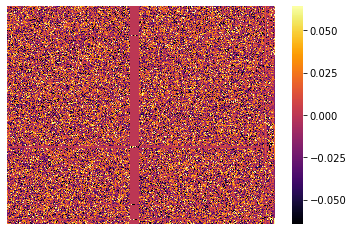

In [20]:
print(np.shape(pset_test))
# plt.imshow(evec_test[3, : , :])
# sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[0, :, :])),
sns.heatmap(pd.DataFrame(pset_test[0, :, :]),
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

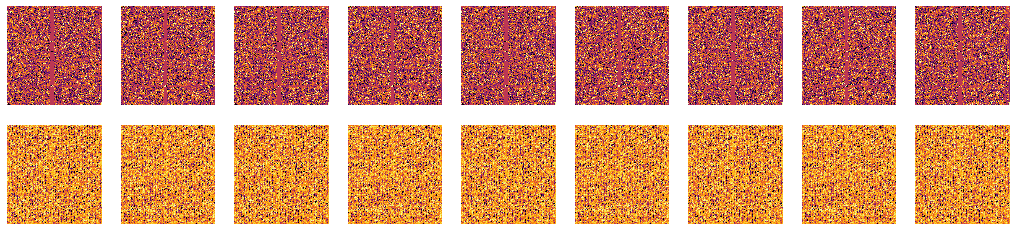

In [21]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[i, :, :])), 
    sns.heatmap(pd.DataFrame(pset_test[i, :, :]), 
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=True, cbar=False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    sns.heatmap(pd.DataFrame(decoded_imgs[i, :, :, 0]),
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=True, cbar=False)

plt.show()

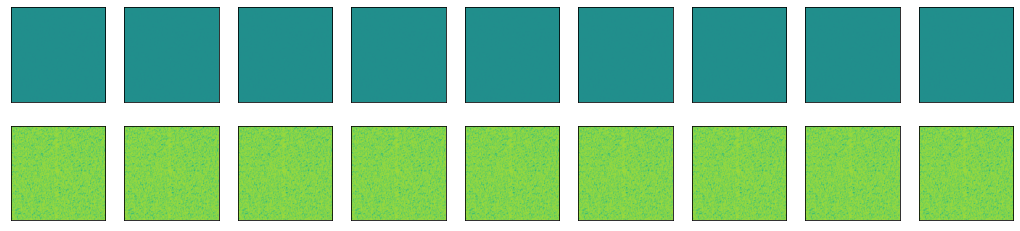

In [22]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     plt.imshow(scaler.inverse_transform(evec_test[i, :, :]))
    plt.imshow(pset_test[i, :, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
# print(np.min(scaler.inverse_transform(evec_test[0, :, :])), np.min(decoded_imgs[0, :, :, 0]))
print(np.min(pset_test[0, :, :]), np.min(decoded_imgs[0, :, :, 0]))

-0.4482694060271616 -0.34377337


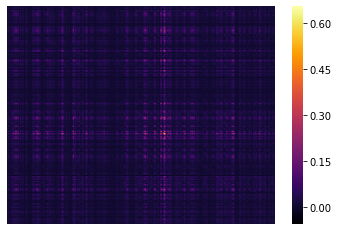

In [26]:
pprima = decoded_imgs[0, :, :, 0]*20
# pprima = eigenvec
new_matrix = pprima @ D @ pprima.T

sns.heatmap(pd.DataFrame(new_matrix),
            xticklabels=False, yticklabels=False, 
            cmap = 'inferno', fmt='g',
            robust=False)